In [1]:
import glob

train_filenames = glob.glob('./train/*.txt')
val_filenames = glob.glob('./val/*.txt')
print(val_filenames)

['./val\\af.txt', './val\\cn.txt', './val\\de.txt', './val\\fi.txt', './val\\fr.txt', './val\\in.txt', './val\\ir.txt', './val\\pk.txt', './val\\za.txt']


In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [3]:
import codecs

# Build the category_lines dictionary, a list of names per language
category_lines_train = {}
train_categories = []

category_lines_val = {}
val_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = codecs.open(filename, "r",encoding='utf-8', errors='ignore').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in train_filenames:
    category = filename.split('\\')[-1].split('.')[0]
    train_categories.append(category)
    lines = readLines(filename)
    category_lines_train[category] = lines

for filename in val_filenames:
    category = filename.split('\\')[-1].split('.')[0]
    val_categories.append(category)
    lines = readLines(filename)
    category_lines_val[category] = lines    

n_categories = len(val_categories)
print('n_categories =', n_categories)

n_categories = 9


In [4]:
import torch

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [5]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))


In [6]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [7]:
input = Variable(letter_to_tensor('A'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

output.size = torch.Size([1, 9])


In [8]:
input = Variable(line_to_tensor('hindu'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

Variable containing:
-2.2004 -2.1458 -2.2256 -2.1791 -2.1750 -2.1990 -2.2971 -2.2178 -2.1439
[torch.FloatTensor of size 1x9]



In [9]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return train_categories[category_i], category_i

print(category_from_output(output))

('za', 8)


In [10]:
import random

def random_training_pair():                                                                                                               
    category = random.choice(train_categories)
    line = random.choice(category_lines_train[category])
    category_tensor = Variable(torch.LongTensor([train_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = fi / line = beneficio termopilas
category = in / line = chaqu pa'in
category = za / line = zabrade
category = fi / line = naapurinvaara
category = fi / line = fisgin
category = cn / line = chuanchingpu
category = fr / line = insfrancue
category = pk / line = hithar bhinda
category = fr / line = fontainelecomte
category = fi / line = turska


In [11]:
import random

def random_validation_pair():                                                                                                               
    category = random.choice(val_categories)
    line = random.choice(category_lines_val[category])
    category_tensor = Variable(torch.LongTensor([val_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_validation_pair()
    print('category =', category, '/ line =', line)

category = in / line = kallam
category = fr / line = saintcrepin
category = za / line = kurees
category = za / line = mafsiagobaba
category = de / line = borkwalde
category = de / line = klein muckrow
category = cn / line = meijie
category = pk / line = chak  tda
category = pk / line = goth darpali
category = de / line = verdelpino de huete


In [12]:
criterion = nn.NLLLoss()


In [13]:
learning_rate = 3e-4 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.RMSprop(rnn.parameters(), lr=learning_rate, momentum = 0.0075)

In [14]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.data[0]

In [15]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000
accuracy = 0
v_accuracy = 0
# Keep track of losses for plotting
current_loss = 0
v_current_loss = 0
all_losses = []
all_losses_v = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    guess, guess_i = category_from_output(output)
    if guess == category:
        accuracy += 1
    current_loss += loss
    
    v_category, v_line, v_category_tensor, v_line_tensor = random_validation_pair()
    v_output = evaluate(v_line_tensor)
    guess, guess_i = category_from_output(v_output)
    category_i = val_categories.index(v_category)
    if guess_i == category_i:
        v_accuracy += 1
    v_loss = criterion(v_output, v_category_tensor)
    v_current_loss += v_loss
    
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        
        all_losses_v.append(v_current_loss / plot_every)
        v_current_loss = 0

5000 5% (0m 41s) 1.4993 toivonoja / in ✗ (fi)
10000 10% (1m 20s) 3.1180 ab garmake sofla / fi ✗ (ir)
15000 15% (1m 59s) 0.9857 frazers / za ✗ (fr)
20000 20% (2m 37s) 1.1206 piazzi de dentro / za ✗ (de)
25000 25% (3m 16s) 3.1916 pilari / fi ✗ (af)
30000 30% (3m 54s) 2.2848 springlee / fr ✗ (in)
35000 35% (4m 33s) 1.3693 linghuchenjia / cn ✗ (in)
40000 40% (5m 13s) 0.6727 sunnyfield estates / fi ✓
45000 45% (5m 54s) 1.6256 ramhusen / fr ✗ (de)
50000 50% (6m 33s) 0.8521 suzan / za ✓
55000 55% (7m 12s) 0.0796 moussey / fr ✓
60000 60% (7m 53s) 0.3521 pengloucun / cn ✓
65000 65% (8m 36s) 0.6369 vinh vue ni / in ✓
70000 70% (9m 19s) 0.5351 ga beafada / af ✓
75000 75% (10m 1s) 0.7040 elshobak el ghaffara / af ✓
80000 80% (10m 50s) 1.4717 le chaffal / fi ✗ (af)
85000 85% (11m 29s) 0.6820 tile ounde / de ✓
90000 90% (12m 9s) 2.6159 corogjafi / fi ✗ (af)
95000 95% (12m 48s) 0.7348 onderste doornknie / de ✓
100000 100% (13m 33s) 2.6154 jirong / in ✗ (ir)


In [16]:
accuracy /= n_epochs
print(accuracy)

0.48744


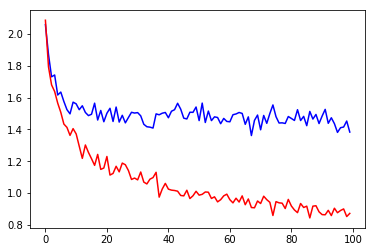

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses, 'b', all_losses_v, 'r')

0.7046


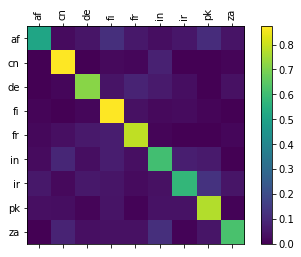

In [18]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed

total_count = 0
correct_count = 0
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_validation_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = val_categories.index(category)
    if category_i == guess_i:
        correct_count += 1
    confusion[category_i][guess_i] += 1
    total_count += 1

accuracy = correct_count / total_count
print(accuracy)
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + train_categories, rotation=90)
ax.set_yticklabels([''] + val_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [19]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line_to_tensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, train_categories[category_index]))
        predictions.append([value, train_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')



> Dovesky
(-0.63) fi
(-0.90) fr
(-3.79) af

> Jackson
(-1.17) de
(-1.68) af
(-1.97) fr

> Satoshi
(-1.08) cn
(-1.35) pk
(-1.81) af


In [20]:
lines = readLines('./cities_test.txt')
out_lines = []
for line in lines:
    line_tensor = Variable(line_to_tensor(line))
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    out_lines.append(guess)
    
with open('labels.txt', 'w') as f:
    for line in out_lines:
        f.write(line + '\n')